## Homeless Encampments in LA

##### Spring 2025
##### Amanda Alonzo
##### I513 Usable AI
##### Indiana University, Bloomington
 


## Machine Learning Predictions

### In this notebook, we will simplify the columns for machine learning tasks by:
- using OneHotEncoding (OHE) for location neighborhood area
- scaling

### We will make predictions for:
- ticket close time and
- number of encampments
##### <i> Prerequisite: 6_zip_visualization.ipynb </i>

TODO: Remove outliers

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [3]:
raw_data_path = "../Dataraw/"
annual_data_path = "../Datafiles/"
generated_data_path = "../Datagen/"

In [4]:
#laod  our data frame from past steps 
df_source = pd.read_csv(generated_data_path+'homeless_camp_closed_2023_parks_zip_ftr_eng_1.csv', low_memory=False)
df_source.head(1)

,SRNumber,CreatedDate,UpdatedDate,ActionTaken,Owner,RequestType,Status,RequestSource,CreatedByUserOrganization,MobileOS,...,Shape__Area_y,Shape__Length_y,close_time_bins,is_county_ind,park_distance_bins,closed_days_scaled,park_distance_scaled,ZIP Code,JENI Need Tier,JENI_TIER
0,1-3202726931,01/01/2023 08:26:17 AM,01/31/2023 01:44:42 PM,SR Created,LASAN,Homeless Encampment,Closed,Self Service,Self Service_SAN,NaN,...,476404.567383,2824.807047,1.0,0,2,0.039295,0.054729,90063.0,High,4.0


## Preparare Data with Transformations for ML Tasks

In [5]:
df_source.shape

(63104, 154)

In [6]:
df_source.close_time_bins.value_counts(), df_source.groupby('close_time_bins').close_time_days_x.min()

(close_time_bins
 3.0    12628
 2.0    12415
 1.0    12229
 4.0     4856
 5.0     2621
 Name: count, dtype: int64,
 close_time_bins
 1.0     11.0
 2.0     51.0
 3.0    101.0
 4.0    201.0
 5.0    301.0
 Name: close_time_days_x, dtype: float64)

In [7]:
#Clean up our data frame - simplify columns
df = df_source[['RequestSource','ZipCodeFmt','Anonymous','AssignTo','park_distance_bins','close_time_bins','is_county_ind','NDS_AN_TYP','COGP_TYP','ACCESS_TYP','JENI_TIER']].copy()


In [8]:
df.columns = df.columns.str.lower()
df.describe()

,zipcodefmt,park_distance_bins,close_time_bins,is_county_ind,jeni_tier
count,63090.000000,63104.000000,44749.000000,63104.000000,63076.000000
mean,90465.801886,0.967989,2.401663,0.980619,3.844679
std,634.715178,0.955762,1.164208,0.137860,1.164308
min,90001.000000,0.000000,1.000000,0.000000,1.000000
25%,90025.000000,0.000000,1.000000,1.000000,3.000000
50%,90048.000000,1.000000,2.000000,1.000000,4.000000
75%,91311.000000,2.000000,3.000000,1.000000,5.000000
max,91607.000000,4.000000,5.000000,1.000000,5.000000


In [9]:
df.columns

Index(['requestsource', 'zipcodefmt', 'anonymous', 'assignto',
       'park_distance_bins', 'close_time_bins', 'is_county_ind', 'nds_an_typ',
       'cogp_typ', 'access_typ', 'jeni_tier'],
      dtype='object')

In [10]:
df.assignto.value_counts()

assignto
NC     22585
EV     12061
WLA    10768
SLA     9317
WV      6791
HB      1190
LSD      391
Name: count, dtype: int64

In [11]:
df.groupby('assignto').agg({'zipcodefmt': ['min', 'max']}   )

zipcodefmt         
                min      max
assignto                    
EV          90068.0  91607.0
HB          90044.0  90744.0
LSD         90007.0  90021.0
NC          90004.0  90732.0
SLA         90001.0  90062.0
WLA         90008.0  90404.0
WV          90049.0  91436.0

In [12]:
df.groupby('zipcodefmt').assignto.value_counts()

zipcodefmt  assignto
90001.0     SLA          206
90002.0     SLA          286
90003.0     SLA         1416
90004.0     NC          1216
90005.0     NC          1434
                        ... 
91602.0     EV           947
91604.0     EV           365
91605.0     EV           903
91606.0     EV          1568
91607.0     EV           219
Name: count, Length: 147, dtype: int64

In [13]:
df.shape

(63104, 11)

In [14]:
df = df.dropna()

In [15]:
df.shape

(44736, 11)

In [17]:
df = df.rename(columns={'close_time_days_x': 'close_time_days' })
df.head(1)

,requestsource,zipcodefmt,anonymous,assignto,park_distance_bins,close_time_bins,is_county_ind,nds_an_typ,cogp_typ,access_typ,jeni_tier
0,Self Service,90063.0,Y,NC,2,1.0,0,Park 5 to 100 Acres,Neighborhood,Open Access,4.0


In [18]:
#ohe the zip code and neighborhood
# add this later depending on svc performance: 'zipcodefmt',

# too many columns making SVC slow
df = pd.get_dummies(df, columns=['assignto'], dtype=int)
#df = pd.get_dummies(df, columns=['zipcodefmt'], dtype=int)


In [19]:
df.head(2)
#assignto abbreviations for values


,requestsource,zipcodefmt,anonymous,park_distance_bins,close_time_bins,is_county_ind,nds_an_typ,cogp_typ,access_typ,jeni_tier,assignto_EV,assignto_HB,assignto_LSD,assignto_NC,assignto_SLA,assignto_WLA,assignto_WV
0,Self Service,90063.0,Y,2,1.0,0,Park 5 to 100 Acres,Neighborhood,Open Access,4.0,0,0,0,1,0,0,0
1,Self Service,90063.0,Y,2,1.0,0,Park 5 to 100 Acres,Neighborhood,Open Access,4.0,0,0,0,1,0,0,0


In [20]:
df.describe()

,zipcodefmt,park_distance_bins,close_time_bins,is_county_ind,jeni_tier,assignto_EV,assignto_HB,assignto_LSD,assignto_NC,assignto_SLA,assignto_WLA,assignto_WV
count,44736.000000,44736.000000,44736.000000,44736.000000,44736.000000,44736.000000,44736.000000,44736.000000,44736.000000,44736.000000,44736.000000,44736.000000
mean,90450.025326,0.987281,2.401556,0.980776,3.858123,0.175094,0.013524,0.006818,0.357587,0.151220,0.181509,0.114248
std,628.118172,0.972493,1.164146,0.137313,1.149946,0.380052,0.115504,0.082289,0.479295,0.358268,0.385444,0.318116
min,90001.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90025.000000,0.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,90046.000000,1.000000,2.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,91311.000000,2.000000,3.000000,1.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,91607.000000,4.000000,5.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
numeric_variables = df.select_dtypes(include=np.number)

## Predict Service Ticket Close Time
### Prepare X and Y

In [24]:
#drop outliers
df_original = df.copy()
df = df[ df['close_time_bins']<4].copy()

In [25]:
df.shape , df_original.shape

((37264, 17), (37264, 17))

In [26]:
x = df[list(numeric_variables.columns)]

In [31]:
x = x.drop(['close_time_days'], axis =1)
x = x.drop(['zipcodefmt'], axis =1)
x = x.drop(['close_time_bins'], axis=1)
x.head(1)

,park_distance_bins,is_county_ind,jeni_tier,assignto_EV,assignto_HB,assignto_LSD,assignto_NC,assignto_SLA,assignto_WLA,assignto_WV
0,2,0,4.0,0,0,0,1,0,0,0


In [28]:
y = df['close_time_bins']

In [29]:
y.head()

0    1.0
1    1.0
2    1.0
3    1.0
6    1.0
Name: close_time_bins, dtype: float64

In [30]:
sc= StandardScaler()
sc.fit(x)
x_scaled = sc.transform(x)    


In [176]:
X_train, X_test, Y_train, Y_test = train_test_split(x_scaled, y, test_size=.2, stratify = y) 


### Logistic Regression

In [177]:
lr = LogisticRegression(C=1000.0, random_state = 0, max_iter  = 1000) 

# train data
lr.fit(X_train, Y_train)

LogisticRegression(C=1000.0, max_iter=1000, random_state=0)

In [178]:
Y_predicted = lr.predict(X_test)



In [179]:
# correlation
corr_lr = pd.Series(Y_predicted).corr(pd.Series(Y_test), method='spearman')

# r2_score
rsquared_lr = r2_score(Y_test, Y_predicted)

In [180]:
rsquared_lr, corr_lr

(-0.741548388943327, np.float64(0.017031586172645843))

In [181]:
# Check the coefficients of the models of 10 features by checking the linear coefficients
print(lr.coef_)

[[-0.03642391  0.03638771 -0.04989815 -0.0107612  -0.04279943  0.03752647
  -0.04031832 -0.01619407 -0.05342893  0.08402651  0.02955137]
 [ 0.08314477 -0.03900341  0.04541962  0.02029794  0.01808392 -0.00052358
   0.01611303  0.03487046  0.0121541  -0.01896052 -0.07069177]
 [-0.04672086  0.00261571  0.00447852 -0.00953674  0.02471551 -0.0370029
   0.02420529 -0.01867639  0.04127482 -0.06506599  0.0411404 ]]


In [182]:
Y_predicted.max(), Y_test.max(), Y_predicted.min(), Y_test.min()

(np.float64(3.0), np.float64(3.0), np.float64(1.0), np.float64(1.0))

In [183]:
Y_predicted

array([1., 2., 3., ..., 3., 2., 3.])

In [184]:
print(" Logistic Regression Initial Classifier:")
print(classification_report(  Y_test, Y_predicted , zero_division=0))  


 Logistic Regression Initial Classifier:
              precision    recall  f1-score   support

         1.0       0.41      0.28      0.33      2445
         2.0       0.37      0.48      0.42      2483
         3.0       0.37      0.38      0.37      2525

    accuracy                           0.38      7453
   macro avg       0.38      0.38      0.37      7453
weighted avg       0.38      0.38      0.37      7453



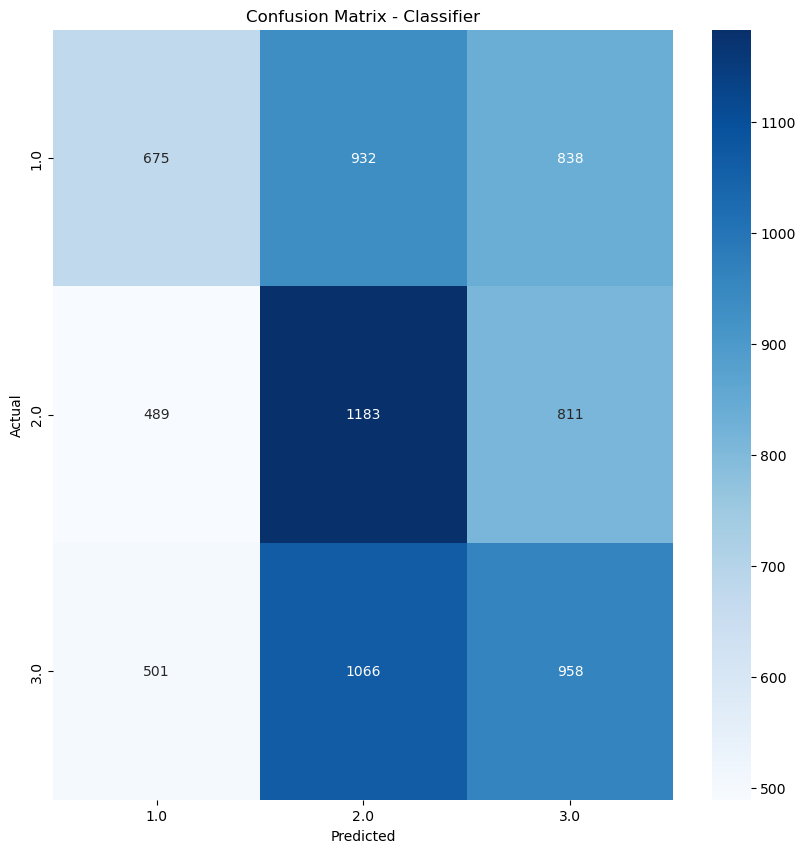

In [185]:
#plot confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_predicted)  

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.title('Confusion Matrix - Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [196]:
# Parameter space for Classifier
# Grid search will evaluate all combinations of these parameters
class_params_grid = {
    'penalty': [  'l2' ],#None
    'max_iter': [2000   ],
    'C': [1.0,2,5]
}

# Perform grid search with cross-validation for Decision Tree Classifier
grid_search_classifier = GridSearchCV(
    LogisticRegression(),
    class_params_grid,
    cv=10, # 10-fold cross-validation
    scoring='f1_macro', # Use F1 score for multiclass classification
    verbose=1
    )

grid_search_classifier.fit(X_train , Y_train)

print("  best grid score in cv: " + str(grid_search_classifier.best_score_))
print("  grid test score: " + str(grid_search_classifier.score(X_test , Y_test)))

Fitting 10 folds for each of 3 candidates, totalling 30 fits
  best grid score in cv: 0.37274174616188976
  grid test score: 0.3731789558760869


In [197]:
class_best_params = grid_search_classifier.best_params_
print(" best params: " + str(class_best_params))

 best params: {'C': 1.0, 'max_iter': 2000, 'penalty': 'l2'}


In [198]:
y_pred = grid_search_classifier.predict(X_test )

In [199]:
grid_search_classification_report = classification_report(Y_test, y_pred,  zero_division=0)
print(" Classification report with whole data")
print(grid_search_classification_report)

 Classification report with whole data
              precision    recall  f1-score   support

         1.0       0.41      0.28      0.33      2445
         2.0       0.37      0.48      0.42      2483
         3.0       0.37      0.38      0.37      2525

    accuracy                           0.38      7453
   macro avg       0.38      0.38      0.37      7453
weighted avg       0.38      0.38      0.37      7453



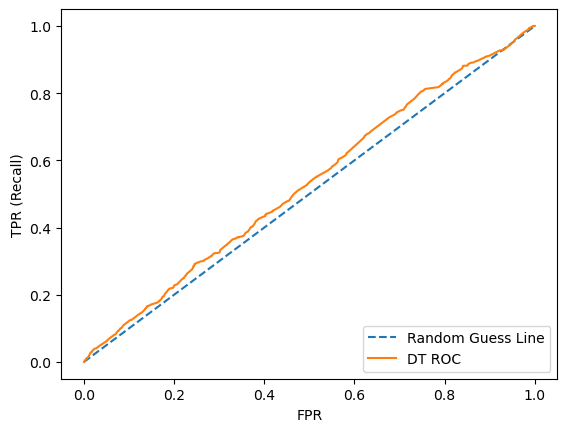

In [200]:
# ROC
from sklearn.metrics import roc_curve, auc
y_score = grid_search_classifier.predict_proba(X_test )
chosenClass = 3.0
chosenClassIndex = grid_search_classifier.classes_.tolist().index(chosenClass)
fpr, tpr, thresholds = roc_curve(Y_test == chosenClass, y_score[:, chosenClassIndex])
roc_auc = auc(fpr, tpr)


# Plot ROC curves: tpr vs fpr (x-axis is fpr, y-axis is tpr)
# Don't forget to draw the random guess line (y=x) use dash line 

# YOUR CODE HERE
plt.plot(fpr, fpr, '--', label='Random Guess Line')
plt.plot(fpr, tpr, label="DT ROC")
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.legend(loc=4)

### SVC


In [201]:
X_train.shape

(29811, 11)

In [202]:
Y_train.shape

(29811,)

In [ ]:
# poly takes a long time
# other types : ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
# adding , probability=False to try to improve performance
svc = SVC(kernel='rbf', C=1000.0,   cache_size=7000, )  
svc.fit(X_train , Y_train )
 

In [ ]:

y_pred = svc.predict(X_test ) 

 

In [205]:
y_pred.size

7453

In [206]:
# correlation
corr_svc = pd.Series(y_pred).corr(pd.Series(Y_test), method='spearman')

# r2_score
rsquared_svc = r2_score(Y_test, y_pred)

In [207]:
rsquared_svc, corr_svc

(-0.02609501350737653, np.float64(0.005547252029055719))

In [ ]:
# Parameter space for Classifier 'poly', , 'sigmoid', 'rgb'
# Grid search will evaluate all combinations of these parameters
class_params_grid = {
    'C': [ 7000, 10000  ],
    'kernel': ['linear'   ] #precomputed gives error 
}

# Perform grid search with cross-validation for Decision Tree Classifier
grid_search_classifier = GridSearchCV(
    SVC(),
    class_params_grid,
    cv=10, # 10-fold cross-validation
    scoring='f1_macro', # Use F1 score for multiclass classification
    verbose=1
    )

grid_search_classifier.fit(X_train_scaled, y_train)

print("  best grid score in cv: " + str(grid_search_classifier.best_score_))
print("  grid test score: " + str(grid_search_classifier.score(X_test , Y_test)))

In [ ]:
best_classifier = SVC(**class_best_params)

In [ ]:
best_classifier.fit(X_train , y_train) # COMPLETE
y_pred_selected = best_classifier.predict(X_test ) # COMPLETE

In [ ]:

# Lastly, rerun the `classification_report()` and print out what your results are.
best_classification_report_selected = classification_report(Y_test, y_pred_selected, zero_division = 0) # COMPLETE
print("Best Classification report ")
print(best_classification_report_selected)



## Random Forest

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(x , y, test_size=.2, stratify = y) 


In [34]:

# Initialize classifiers 
classifier = RandomForestClassifier(n_estimators  = 100)   
# Fit the model
classifier.fit(X_train, Y_train) # COMPLETE



RandomForestClassifier()

In [35]:
# Predict on the test set
y_pred =  classifier.predict(X_test) # COMPLETE
# Evaluate the  model
print("Random Forest Classifier:")
print(classification_report(  Y_test, y_pred , zero_division=0)) # COMPLETE


Random Forest Classifier:
              precision    recall  f1-score   support

         1.0       0.42      0.51      0.46      2445
         2.0       0.40      0.30      0.34      2483
         3.0       0.42      0.43      0.42      2525

    accuracy                           0.41      7453
   macro avg       0.41      0.41      0.41      7453
weighted avg       0.41      0.41      0.41      7453



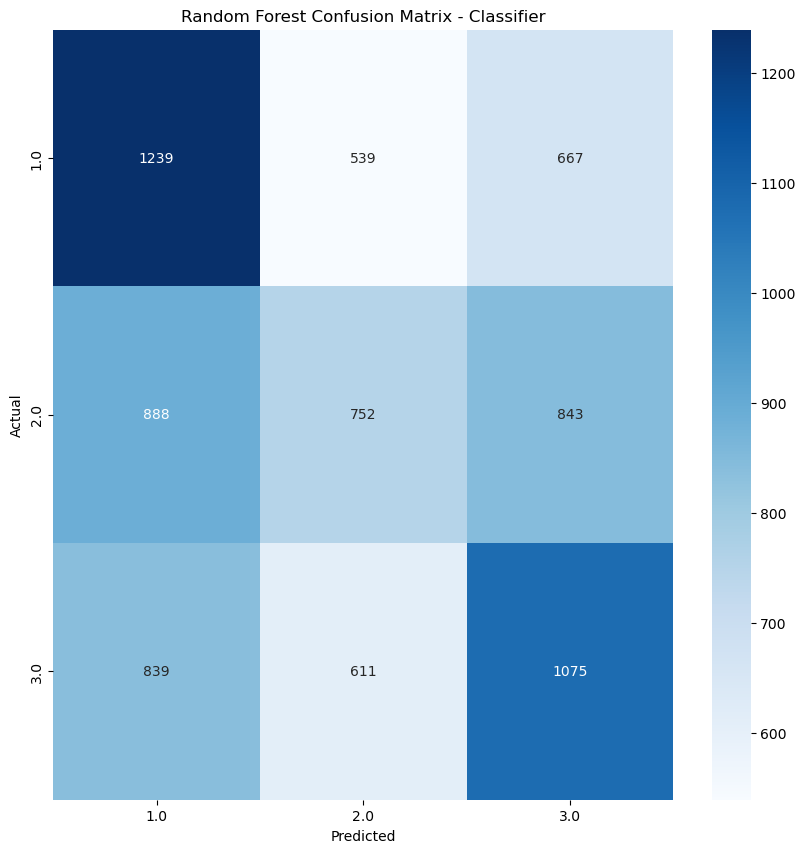

In [37]:
#plot confusion matrix
conf_matrix = confusion_matrix(Y_test, y_pred)  # COMPLETE

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels= classifier.classes_, yticklabels= classifier.classes_)
plt.title('Random Forest Confusion Matrix - Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Parameter space for Classifier
# Grid search will evaluate all combinations of these parameters
class_params_grid = {
    'n_estimators': [100, 200, 500],  
    'criterion': ['gini', 'entropy', 'log_loss' ] 
}

# Perform grid search with cross-validation for Decision Tree Classifier
grid_search_classifier = GridSearchCV(
    RandomForestClassifier(),
    class_params_grid,
    cv=10, # 10-fold cross-validation
    scoring='f1_macro', # Use F1 score for multiclass classification
    verbose=1
    )

grid_search_classifier.fit(X_train, Y_train)

print("  best grid score in cv: " + str(grid_search_classifier.best_score_))
print("  grid test score: " + str(grid_search_classifier.score(X_test, Y_test)))

Fitting 10 folds for each of 9 candidates, totalling 90 fits


In [ ]:
class_best_params = grid_search_classifier.best_params_
print("random forest best params: " + str(class_best_params))

In [ ]:
y_pred = grid_search_classifier.predict(X_test)

In [ ]:
grid_search_classification_report = classification_report(Y_test, y_pred)
print(" Classification report with whole data")
print(grid_search_classification_report)

In [ ]:
best_classifier = RandomForestClassifier(**class_best_params)

In [ ]:
best_classifier.fit(X_train_selected , y_train) # COMPLETE
y_pred_selected = best_classifier.predict(X_test_selected ) # COMPLETE

In [ ]:
# Lastly, rerun the `classification_report()` and print out what your results are.
best_classification_report_selected = classification_report(y_test, y_pred_selected, zero_division = 0) # COMPLETE
print("Best Classification report with selected features")
print(best_classification_report_selected)


In [ ]:
# Feature importance
feature_importances_dt = best_classifier.feature_importances_  
df_feature_importance = pd.DataFrame(feature_importances_dt)
df_features = pd.DataFrame(x_features)
df_feature_importances = pd.concat([df_features, df_feature_importance], axis=1 )
df_feature_importances.columns = [ 'feature_name',  'importance' ]  
df_feature_importances = df_feature_importances.sort_values(by='importance', ascending=False)
# Plot feature importances (you can use matplotlib or seaborn)
plt.figure(figsize=(10, 6))
#df_feature_importances.plot(kind='bar', title=f"Importance")
plt.plot(df_feature_importances['feature_name'], df_feature_importances['importance'], 'bo-' )
#show horizontal line for 20 
#plt.axhline(y=20, color='r', linestyle='--')
plt.xlabel("Feature")
plt.ylabel('Importance')
plt.show()

## Predict Volume of Encampment Tickets 


### Prepare data


In [ ]:
numeric_variables.columns.size

In [ ]:
num_cols = list(numeric_variables) 
#zip_cols = num_cols[3:]
#zip_cols[0]
num_cols[0:5]

In [ ]:

new_df = df.copy()
counts_df = new_df.groupby(['jini_tier','park_distance_bins','assignto_EV','assignto_HB','assignto_LSD','assignto_NC','assignto_SLA','assignto_WLA','assignto_WV']).size().reset_index(name="cnt")

#counts_df = new_df.groupby(num_cols).size().reset_index(name='count')


In [ ]:
counts_df.shape

In [ ]:
counts_df.dropna()
counts_df.size

In [ ]:
counts_df.shape

In [ ]:
counts_df.head(1)

In [330]:
counts_df[counts_df['cnt'].isna()==True].size

0

In [334]:
#counts_df = counts_df.dropna()
counts_df.shape

(34, 9)

In [335]:

x  = counts_df.copy() 
x.shape

(34, 9)

In [338]:

x.drop(['cnt'] , axis=1)
x.dropna()


,park_distance_bins,assignto_EV,assignto_HB,assignto_LSD,assignto_NC,assignto_SLA,assignto_WLA,assignto_WV,cnt
0,0,0,0,0,0,0,0,1,1282
1,0,0,0,0,0,0,1,0,3213
2,0,0,0,0,0,1,0,0,3970
3,0,0,0,0,1,0,0,0,11306
4,0,0,0,1,0,0,0,0,120
5,0,0,1,0,0,0,0,0,545
6,0,1,0,0,0,0,0,0,3671
7,1,0,0,0,0,0,0,1,1982
8,1,0,0,0,0,0,1,0,3546
9,1,0,0,0,0,1,0,0,4032


In [357]:
y = counts_df['cnt']
#y = y.copy()
#y.min(), y.max(), y['volume_cnt'].size, y.size
y.size

34

In [358]:
y.head(1)

0    1282
Name: cnt, dtype: int64

In [359]:
#x.shape, y.shape, counts_df.shape, df.shape,  y['cnt'].shape

In [345]:
y['cnt']

0      1282
1      3213
2      3970
3     11306
4       120
5       545
6      3671
7      1982
8      3546
9      4032
10     7397
11      143
12      402
13     4146
14     2219
15     2376
16     1266
17     3593
18      126
19      199
20     3746
21     1034
22     1037
23       33
24      269
25        2
26       19
27      431
28      268
29      588
30        1
31       13
32       24
33       65
Name: cnt, dtype: int64

In [376]:

 X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=.2) 


In [385]:
len(X_train.index), len(X_test.index), len(Y_train.index), len(Y_test.index)

(27, 7, 27, 7)

## Linear Regression

In [65]:
linear = LinearRegression()

# train data
linear.fit(X_train, Y_train)

LinearRegression()

In [66]:
Y_predicted = linear.predict(X_test)


In [67]:
# correlation method{‘pearson’, ‘kendall’, ‘spearman’} 
# as per professor, spearman because data is skewed 
corr_linear = pd.Series(Y_predicted).corr(pd.Series(Y_test), method='spearman')

# r2_score
rsquared_linear = r2_score(Y_test, Y_predicted)

In [ ]:
rsquared_linear, corr_linear

In [68]:
# Check the coefficients of the models of 10 features by checking the linear coefficients
print(linear.coef_)

[-3.12638804e-13 -2.66085106e+02  8.62914894e+02  1.59161573e-12
  8.80914894e+02  3.99914894e+02  3.00914894e+02 -3.60085106e+02
 -3.20851064e+01  5.28914894e+02  1.70530257e-13 -1.83085106e+02
  5.36914894e+02  1.92914894e+02 -4.20851064e+01 -1.17085106e+02
  5.27914894e+02  3.32914894e+02  2.29914894e+02 -2.70851064e+01
  0.00000000e+00  3.66914894e+02  1.98951966e-13 -1.13686838e-13
  2.50891489e+03  3.76914894e+02  4.49148936e+01 -1.98085106e+02
 -1.87085106e+02  6.01914894e+02  5.11590770e-13 -1.34085106e+02
  5.71914894e+02  3.13914894e+02 -2.41085106e+02 -2.27085106e+02
 -1.14085106e+02 -3.75085106e+02  2.56914894e+02  4.26325641e-14
  5.68434189e-13  2.27373675e-13  4.69914894e+02 -3.43085106e+02
  2.57791489e+03 -3.86085106e+02 -3.01085106e+02 -5.40012479e-13
 -1.90851064e+01  1.23791489e+03  3.19148936e+01  2.22914894e+02
 -2.18085106e+02  1.13686838e-13  1.13686838e-13 -5.51085106e+02
 -5.44085106e+02 -5.08085106e+02 -5.47085106e+02 -5.51085106e+02
  4.54747351e-13 -3.41060

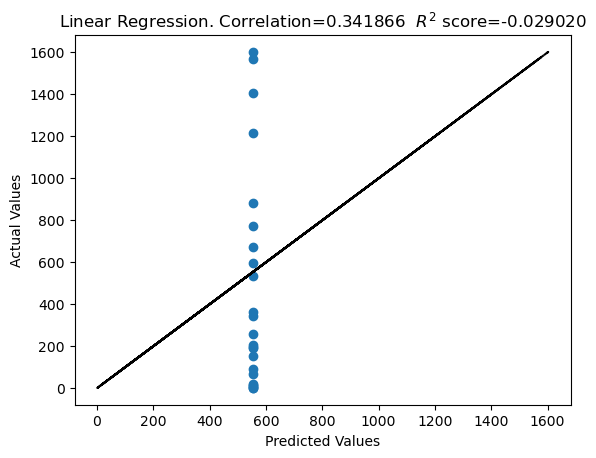

In [69]:
plt.scatter(Y_predicted, Y_test)

plt.title("Linear Regression. Correlation=%f  $R^2$ score=%f" % (corr_linear, rsquared_linear))

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

# plot a diagonal line
plt.plot(Y_test, Y_test, 'k--') # 'k--' = black dashed lines
plt.show()

# Graphical representati


## Predict Volume of Encampment Tickets

### 2. SVR


In [347]:
x.size

306

In [348]:
x.head(1)

,park_distance_bins,assignto_EV,assignto_HB,assignto_LSD,assignto_NC,assignto_SLA,assignto_WLA,assignto_WV,cnt
0,0,0,0,0,0,0,0,1,1282


In [362]:
y.head()

0     1282
1     3213
2     3970
3    11306
4      120
Name: cnt, dtype: int64

In [289]:
#counts_df.to_csv(generated_data_path +'wip3.csv' )

In [386]:

 X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=.2) 


In [387]:
len(X_train.index), len(X_test.index), len(Y_train.index), len(Y_test.index)

(27, 7, 27, 7)

In [364]:
# poly takes a long time
# other types : ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
svm= SVR(kernel='rbf', C=1.0 )  
svm.fit(X_train , Y_train )
y_pred = svm.predict(X_test ) 
 

In [389]:
len(y_pred)

7

In [365]:
# 3 columns SVC
# linear and rbf - 0.6319473034170441
# correlation
corr_svr = pd.Series(y_pred).corr( Y_test, method='spearman') 

# r2_score
rsquared_svr = r2_score(Y_test, y_pred)

In [366]:
Y_predicted.size

24

In [369]:
X_test.size

63

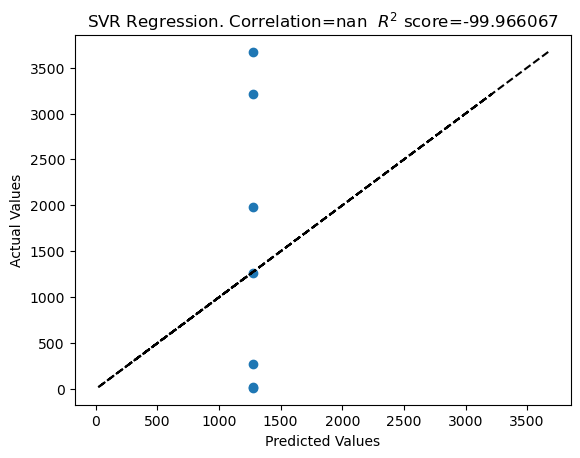

In [390]:
plt.scatter(y_pred, Y_test)

plt.title("SVR Regression. Correlation=%f  $R^2$ score=%f" % (corr_svr, rsquared_svr))

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

# plot a diagonal line
plt.plot(Y_test, Y_test, 'k--') # 'k--' = black dashed lines
plt.show()

# Graphical representati

In [391]:
# Save to file for next step ML
df.to_csv(generated_data_path +'homeless_camp_closed_2023_parks_simplified_2.csv', index=False)

## Next: Try clustering - 6_ml_cluster.ipynb